In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./cnus.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 3381928
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Remove all non-printable characters
file = ''.join(list(filter((lambda x: x in all_chars), file)))

In [4]:
file_len = len(file)
print('Length of file: {}'.format(file_len))

Length of file: 3381831


In [5]:
# Get a random sequence of the Sherlock dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

In [6]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [7]:
class Net(nn.Module):
    def __init__(self, activation='RNN'):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        if activation == 'RNN':
            self.activation = nn.RNNCell(self.input_size, self.hidden_size)
        elif activation == 'LSTM':
            self.activation = nn.LSTMCell(self.input_size, self.hidden_size)
        
        self.act = activation
            
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        if self.act == 'RNN':
            hidden = self.activation(input, hidden)
            output = self.linear(hidden)
            return output, hidden
        else:
            hidden, cell = self.activation(input, hidden)
            output = self.linear(hidden)
            return output, hidden, cell

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
    def init_cell(self):
        # Initial cell state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 

In [8]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    cell = net.init_cell()      # Initial cell state
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.
    
    if net.act == 'RNN':
        for t in range(seq_len):    # For each one in the input sequence.
            output, hidden = net(input[t], hidden)
            loss += loss_func(output, target[t])
    else:
        for t in range(seq_len):    # For each one in the input sequence.
            output, hidden, cell = net(input[t], (hidden, cell))
            loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [9]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    cell          = net.init_cell()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # If input net is RNN
    if net.act == 'RNN':
        # Use initial string to "build up" hidden state.
        for t in range(len(init_seq) - 1):
            output, hidden = net(init_input[t], hidden)
        # Set current input as the last character of the initial string.
        input = init_input[-1]
        
        # Predict more characters after the initial string.
        for t in range(predicted_len):
            # Get the current output and hidden state.
            output, hidden = net(input, hidden)
        
            # Sample from the output as a multinomial distribution.
            predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
            # Add predicted character to the sequence and use it as next input.
            predicted_char  = all_chars[predicted_index]
            predicted_seq  += predicted_char
        
            # Use the predicted character to generate the input of next round.
            input = seq_to_onehot(predicted_char)[0].to(device)
    
    # If input net is LSTM       
    else:
        # Use initial string to "build up" hidden state.
        for t in range(len(init_seq) - 1):
            output, hidden, cell = net(init_input[t], (hidden, cell))
        # Set current input as the last character of the initial string.
        input = init_input[-1]
        
        # Predict more characters after the initial string.
        for t in range(predicted_len):
            # Get the current output and hidden state.
            output, hidden, cell = net(input, (hidden, cell))
        
            # Sample from the output as a multinomial distribution.
            predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
            # Add predicted character to the sequence and use it as next input.
            predicted_char  = all_chars[predicted_index]
            predicted_seq  += predicted_char
        
            # Use the predicted character to generate the input of next round.
            input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

### Experiment

In [10]:
# Perform n_trials each for standard RNN and LSTM.

n_trials    = 3      # Number of trials per model
iters       = 20000  # Number of training iterations per trial.
print_iters = 100    # Number of iterations for each log printing.

In [11]:
# The loss variables.
all_losses_rnn = np.zeros(int(iters / print_iters))

# Training procedure.
for i in range(n_trials):
    net_rnn = Net()     # Create a new network instance.
    net_rnn.to(device)
    opt_rnn       = torch.optim.Adam(net_rnn.parameters(), lr=0.005)
    loss_func = nn.CrossEntropyLoss()
    losses = np.array([])
    loss_sum = 0
    for j in range(iters):
        input, target = get_input_and_target()            # Fetch input and target.
        input, target = input.to(device), target.to(device) # Move to GPU memory.
        loss      = train_step(net_rnn, opt_rnn, input, target)   # Calculate the loss.
        loss_sum += loss.item()                                  # Accumulate the loss.

        # Print the log.
        if j % print_iters == print_iters - 1:
            print('rnn_trial:{}, iter:{}/{} loss:{}'.format(i, j, iters, loss_sum / print_iters))
            print('generated sequence: {}\n'.format(eval_step(net_rnn)))
              
            # Track the loss.
            losses = np.append(losses, loss_sum / print_iters)
            loss_sum = 0
    all_losses_rnn += losses
    
mean_losses_rnn = all_losses_rnn / n_trials

rnn_trial:0, iter:99/20000 loss:3.0149088311195373
generated sequence: WM .yotor ahmmro  heeaxig iT hotfim y'ers weorsl  othlry   e rkrn a a led iunoot dt  ose   s , p Im d

rnn_trial:0, iter:199/20000 loss:2.5957364106178282
generated sequence: Wvuedclis  tomerroty ts mefhintyuler cesont"ey dtknde?disdit  he houvkr, har Ting in.ore
 k
 monomeon

rnn_trial:0, iter:299/20000 loss:2.4143584609031676
generated sequence: Waveetraspeast to

     thep,
a   thacI bandis pmons the sas-ofpaseteYind beds soind in. the pudy..I


rnn_trial:0, iter:399/20000 loss:2.2768567776679993
generated sequence: Woon,
     "

     "Af the hacint te is Ire. at iad the chalk is is is ge'io, ing min? t
      Bad "W

rnn_trial:0, iter:499/20000 loss:2.1708909237384795
generated sequence: Wend ag heot ro fintre
     bre pod anosh-

     Lupnsoilure
     nicin or
     prerlen.

      Whanp

rnn_trial:0, iter:599/20000 loss:2.106221311092377
generated sequence: Whed ssaiins of
     the save brobreHnvert cucps siren 

rnn_trial:0, iter:4799/20000 loss:1.759950270652771
generated sequence: Weys. I sury in aghen ate usele.

     "But o to tter ther a sharmy mes, sho or our deay. He look sti

rnn_trial:0, iter:4899/20000 loss:1.7770441353321076
generated sequence: Will
     Cloident wand fure cone, he bent withwore! Wold, from if youlloct, rethe what eevers where 

rnn_trial:0, iter:4999/20000 loss:1.7556602215766908
generated sequence: Well whath herraidase, anded. I was sobly-sowarible.

 
     Vustestan. It ouls. If you vast had cwas

rnn_trial:0, iter:5099/20000 loss:1.7402511966228484
generated sequence: We bugan'ves on the was enou. I froppee mine. EA as no dinve outtalm supsiaded us no
     rome makfor

rnn_trial:0, iter:5199/20000 loss:1.7512087976932527
generated sequence: Wiod I is as as eave he was inter befere's upran. The sars
     shave I
    ."

     "I and yot
     

rnn_trial:0, iter:5299/20000 loss:1.7385446393489838
generated sequence: Whpor durkith insteannay he orling and wish and 

rnn_trial:0, iter:9499/20000 loss:1.7358119678497315
generated sequence: Way steprition con jow."

     "I's dole objenly who sught hads of you casting hirraghy own
     shac

rnn_trial:0, iter:9599/20000 loss:1.7003621995449065
generated sequence: We presuntigg younatet, at
     him, that yepruee this man up a
     came arregnonct--,
     not a Nu

rnn_trial:0, iter:9699/20000 loss:1.6898574149608612
generated sequence: Wens, fool of the laster a rooms heard as
     of the angenion the
     into Honkesorn, stapstions av

rnn_trial:0, iter:9799/20000 loss:1.6957083320617676
generated sequence: What's flayes. He every anev 'remance. Scervehhed his asked of husher.!"I, Whom my combono
     hill.

rnn_trial:0, iter:9899/20000 loss:1.7169000101089478
generated sequence: Wh the findon frome fill on the bloottames on must will."

     "What
     Dome to we these. No at ag

rnn_trial:0, iter:9999/20000 loss:1.6968615138530732
generated sequence: When this the liff nog to, with enstinatised to

rnn_trial:0, iter:14199/20000 loss:1.6579045009613038
generated sequence: Wet
     and the his had not, looks, sinngghthing, was, Proth save the stpacining
     excem in volle

rnn_trial:0, iter:14299/20000 loss:1.671894680261612
generated sequence: Wive beecters and shouvep efoullowed in my dowef urtien, to me the bound goifedured fissester. Acter 

rnn_trial:0, iter:14399/20000 loss:1.6748746132850647
generated sequence: Wey. The sury, it
     the his Cowers up, which Bepoutout old the santer the thirruss the tropperore 

rnn_trial:0, iter:14499/20000 loss:1.6547527194023133
generated sequence: Whis meswers direltist litts, and that this uttern, become.

     "Not of no usent Got St. She from h

rnn_trial:0, iter:14599/20000 loss:1.6410621297359467
generated sequence: Wit, his hall was I
     extless dyen in the moundce and I
     purners the menes, and he wough I vat

rnn_trial:0, iter:14699/20000 loss:1.636257246732712
generated sequence: Why man, treds teuding
     impleced had se

rnn_trial:0, iter:18899/20000 loss:1.6711554968357085
generated sequence: Whtloughtab entale, 'yostien of cer hog that the 'ad old Dindt, wer he can the mown me."

     He an 

rnn_trial:0, iter:18999/20000 loss:1.6336951243877411
generated sequence: Whowonou in the evedl.  I seen they mart us neve the eriller, treared indow!" ropp have do you as els

rnn_trial:0, iter:19099/20000 loss:1.6552264499664306
generated sequence: Whan frage my seesse wordon," same. I crature. I go houged might have sememers, and he bedcays are so

rnn_trial:0, iter:19199/20000 loss:1.6317874145507814
generated sequence: Whall welkmeation sut might pirs thoughy, and a wore and
     the Endy. Ael,
     seyt, ss what conve

rnn_trial:0, iter:19299/20000 loss:1.6668350160121919
generated sequence: Wersege."

     Them, aromeresen
     ofceered of leashoring you beg't beling dy?"

     I the baft,


rnn_trial:0, iter:19399/20000 loss:1.6669960403442383
generated sequence: Way to men yoo staded of a some asousen r

rnn_trial:1, iter:3599/20000 loss:1.8185854375362396
generated sequence: Weld more," hadgurivinx.

     "to-dsend, and foo think reat. The booknow. "I vended a could waysed.


rnn_trial:1, iter:3699/20000 loss:1.8022250735759735
generated sequence: Will I doind
     he or that I with way, I and pltroing of. Ind ifuill to grouted
     tiunds a vily 

rnn_trial:1, iter:3799/20000 loss:1.7733721375465392
generated sequence: Wet liments sawning it or a
     mortiR thares sacter, on what be. Holmes wishing it you pEgabs. Holm

rnn_trial:1, iter:3899/20000 loss:1.7747597098350525
generated sequence: Weys, and and whish, and wondenly in thanr
     Dos khould Len which sitheressediscore inrvyou'tlemas

rnn_trial:1, iter:3999/20000 loss:1.8080928897857667
generated sequence: Weted deact. "It a
     laster under dow- he boatul," sail nop," beal!"

     "Hele, and
     betsed 

rnn_trial:1, iter:4099/20000 loss:1.7618637311458587
generated sequence: Wees timesgio af My. I'ld thet pould was were i

rnn_trial:1, iter:8299/20000 loss:1.7161737811565398
generated sequence: We cretsing
     alyens," said Holmes that time moy.  thougly dintwats, and ling him antameno a time 

rnn_trial:1, iter:8399/20000 loss:1.6995691764354706
generated sequence: Where were he to you the littling the for a camile by the treast here of cornow itall weence earned, 

rnn_trial:1, iter:8499/20000 loss:1.686958637237549
generated sequence: Wild was
     sand of
        neavy jasted. Hotghtainned had he, deonanod, I had countashind thought 

rnn_trial:1, iter:8599/20000 loss:1.7207944619655609
generated sequence: We for for a no somambout bo taly and in halk comp a yend
     nothepfibfoy Jut candon'    Sis way. B

rnn_trial:1, iter:8699/20000 loss:1.6712539041042327
generated sequence: We line lustil
     somesuinst becobsing anote ichiorsen an you meantle
     his wishore had looked y

rnn_trial:1, iter:8799/20000 loss:1.6888806056976318
generated sequence: We seet l
     Wan, the asmen, the cappand, tell

rnn_trial:1, iter:12999/20000 loss:1.6817931640148163
generated sequence: We lither Bakered
     moreyer have a, some, all the ever by I azle inglouson ofternd als interly rea

rnn_trial:1, iter:13099/20000 loss:1.7139713895320892
generated sequence: Wath the Wein At out for I
         may held to on suitly composerge were were abvery out utsare prea

rnn_trial:1, iter:13199/20000 loss:1.6750314462184905
generated sequence: Whesple
     fionf--up. I waistens who in; have and from meruots of as sose and fonn puch go I house 

rnn_trial:1, iter:13299/20000 loss:1.685149576663971
generated sequence: Whysement his
     grecks will musen by Helly over were shert Pand abse the Averyivilely liked breve 

rnn_trial:1, iter:13399/20000 loss:1.6828489112854004
generated sequence: We heak my morggled to cimpser of the sawing
     serve percoment?'

     "I chaok?"

     "Seave
   

rnn_trial:1, iter:13499/20000 loss:1.6972081792354583
generated sequence: We is over at had
     to may his very it


rnn_trial:1, iter:17699/20000 loss:1.687208560705185
generated sequence: Wis this
     diseed to mes. Theined."

     "Iores."

     "Disit that suat, soardster. Oh mosittere

rnn_trial:1, iter:17799/20000 loss:1.6573437082767486
generated sequence: Will."

     "Shawe opt. I meally cOnlesing somep is finkeagread there is sofr atlled off your womk a

rnn_trial:1, iter:17899/20000 loss:1.7090759921073913
generated sequence: Wondars. 'We can a book into your dank," said I wosterverrphired our handain
     an if out so once s

rnn_trial:1, iter:17999/20000 loss:1.6731099367141724
generated sequence: We canned ou sagrifityogs doptendon curoutt our moot yond pliops halt did found I could he faw and in

rnn_trial:1, iter:18099/20000 loss:1.6671151876449586
generated sequence: We said simise of the rear vialt and ofther?"

        A more caulvatiors I
     inamped to drair pra

rnn_trial:1, iter:18199/20000 loss:1.6803543174266815
generated sequence: We sombor. It amagm at this were intersari

rnn_trial:2, iter:2399/20000 loss:1.871785922050476
generated sequence: Whe dave not wave some his wand
     ld it mich will strowf."

     "Stiogoars obriltar
     with dot

rnn_trial:2, iter:2499/20000 loss:1.8700224709510804
generated sequence: Wercereld I pase is the hame a deer anoPrenis the inaresting bat the bin oucd ssice there was ham
   

rnn_trial:2, iter:2599/20000 loss:1.8498413264751434
generated sequence: Wham tre tert, grrlane
     sagged! Thime the rorkconmer, uco cho'quen, Plop and,"  he
     and to
  

rnn_trial:2, iter:2699/20000 loss:1.8830746352672576
generated sequence: Were as the whan, and monch led were Amily, saccach pledor lot intanch a thar deradols
     pach."

 

rnn_trial:2, iter:2799/20000 loss:1.8300131785869598
generated sequence: Werse. Wirear preable tell, and from hap and not a hat he fris gaid-diond you beningr?"
     cond of 

rnn_trial:2, iter:2899/20000 loss:1.8442530882358552
generated sequence: Wald he frive that of wat me. St hove lasab wita

rnn_trial:2, iter:7099/20000 loss:1.7659161269664765
generated sequence: Woard fest. How. We have of the nair. Leffert sawt if is have are he sonrasuancil to of suply of S er

rnn_trial:2, iter:7199/20000 loss:1.73658038854599
generated sequence: Ws wor,
     seem. I quined of it?"

     "It hun Poocted the
     cogated.

     "Mehulted, and ever

rnn_trial:2, iter:7299/20000 loss:1.760629494190216
generated sequence: Wall gand at and be was had a wogld.

     "Mand rimatttor myst tid ong Griald by these had ther, on'

rnn_trial:2, iter:7399/20000 loss:1.7523540830612183
generated sequence: When and yhush vispond that in dam Pholact coll the Pay his nace had
     the comans of the mowied an

rnn_trial:2, iter:7499/20000 loss:1.7209852719306946
generated sequence: Wat
     soad wirst his camely who stinave in Lit, thly give for sh!'ll, thonisins, is aseladies of I

rnn_trial:2, iter:7599/20000 loss:1.7078697752952576
generated sequence: Wasencesserves'rlow there."

     "Well haddly."



rnn_trial:2, iter:11899/20000 loss:1.7197345364093781
generated sequence: Whered he way served moubl, he is it' have been of Bide's taken, and alls. It waster has blee far in


rnn_trial:2, iter:11999/20000 loss:1.689942021369934
generated sequence: We'l'd tend. Hodmes porite all I straninibleler! and bick
     I 'to alshing bether doFgands all as a

rnn_trial:2, iter:12099/20000 loss:1.6834264206886291
generated sequence: When I polical swains ame dregendly
     out. So the stils though."

     "Gor only yourly that out l

rnn_trial:2, iter:12199/20000 loss:1.711239640712738
generated sequence: Wond
     mandersidered man, so hime
     the very breake
     deng
     embergucker whrookidion ther

rnn_trial:2, iter:12299/20000 loss:1.7392241859436035
generated sequence: Wont a trieleed that' landing flan.'

     "Yes war in the Grder theor with?"

     "Clloct: He narr,

rnn_trial:2, iter:12399/20000 loss:1.7060566425323487
generated sequence: Wherly follow
     of comblight upon of the

rnn_trial:2, iter:16599/20000 loss:1.6753426122665405
generated sequence: Wing intil upon this to more, the
     at me that I stuatily sow facarning by of canlures. And unnod 

rnn_trial:2, iter:16699/20000 loss:1.6820494222640991
generated sequence: We all, he sbial into Semach, and it of our his byemed the pressy is two had my out's seew awayed is


rnn_trial:2, iter:16799/20000 loss:1.684637849330902
generated sequence: We tome litto Holmes; befresse, Mut over sow I have at tursed readlautratt us woodner. I ture to
    

rnn_trial:2, iter:16899/20000 loss:1.6753135788440705
generated sequence: Wat somures let.
  T pld into
     yoursunts
     a
     have

     thin I nallineld which snoll mond

rnn_trial:2, iter:16999/20000 loss:1.676753145456314
generated sequence: Watted hole drioly on you has a a cave that have
     here aboution as out that we housed
     a cail

rnn_trial:2, iter:17099/20000 loss:1.6672699856758117
generated sequence: What varks, surelve anyons ghath-roefpirily

In [12]:
all_losses_lstm = np.zeros(int(iters / print_iters))

for i in range(n_trials):
    net_lstm = Net('LSTM')    # Create a new network instance.
    net_lstm.to(device)
    opt_lstm      = torch.optim.Adam(net_lstm.parameters(), lr=0.005)
    loss_func = nn.CrossEntropyLoss()
    losses = np.array([])
    loss_sum = 0
    for j in range(iters):
        input, target = get_input_and_target()            # Fetch input and target.
        input, target = input.to(device), target.to(device) # Move to GPU memory.
        loss      = train_step(net_lstm, opt_lstm, input, target)   # Calculate the loss.
        loss_sum += loss.item()                                  # Accumulate the loss.

        # Print the log.
        if j % print_iters == print_iters - 1:
            print('lstm_trial:{}, iter:{}/{} loss:{}'.format(i, j, iters, loss_sum / print_iters))
            print('generated sequence: {}\n'.format(eval_step(net_lstm)))
              
            # Track the loss.
            losses = np.append(losses, loss_sum / print_iters)
            loss_sum = 0
    all_losses_lstm += losses

mean_losses_lstm = all_losses_lstm / n_trials

lstm_trial:0, iter:99/20000 loss:3.0881905651092527
generated sequence: WQrH Gofsit  lafhwdak.mf tinnse ir wam cenf wIiftyrt
 "
        teoTosttn.,a sd  gj anealIlnclte lds 

lstm_trial:0, iter:199/20000 loss:2.6121486806869507
generated sequence: Wgjtsul,hil h" cove 

     avhis thpos amute sbele mous hety Ger 
    mre oEttr
    ha vacicbwle tofa

lstm_trial:0, iter:299/20000 loss:2.3419703388214113
generated sequence: Weny ~heas " aos t andiPpod by he lase veet.is he oudumetfe fkat asoapsybis. ome
    mverreas. ang or

lstm_trial:0, iter:399/20000 loss:2.2632899141311644
generated sequence: Woron wous the trourner be the wewerz oukired maly aoded at
     Wiche vister af
    ""t ar tfuy. hem

lstm_trial:0, iter:499/20000 loss:2.1762581992149355
generated sequence: Wchen'owantsime on beisens
     gata wyo he the nofstu!r_an as ot rgyof Char stolsinangs walstond in 

lstm_trial:0, iter:599/20000 loss:2.0907800710201263
generated sequence: Wnyhe dard wperve hin  har wema mal8ap live."

 

lstm_trial:0, iter:4799/20000 loss:1.6169861233234406
generated sequence: Wallers but oth rewasratured ut the past in the betwning
     as a daust now size mirdurant mossenny.

lstm_trial:0, iter:4899/20000 loss:1.5770378088951111
generated sequence: Well we round. That's am chaassar mast he of Holmes; creys in nimked, Watson on the sick--turn bay th

lstm_trial:0, iter:4999/20000 loss:1.5728725838661193
generated sequence: Wandtion, you could nothinise left him. Werrow
     where it is four a back trope. Trecure."

     "V

lstm_trial:0, iter:5099/20000 loss:1.6020683789253234
generated sequence: We wait up without to bed spragions with they camp Obery sucting friems anywimed possoked for sir pat

lstm_trial:0, iter:5199/20000 loss:1.5683066308498383
generated sequence: Whurder lay young onces, as I ady you have llight impaed aw was somethor out?" -"Ho is all how a buse

lstm_trial:0, iter:5299/20000 loss:1.5887410306930543
generated sequence: We at the very upon the possions
     the

lstm_trial:0, iter:9499/20000 loss:1.4846023869514466
generated sequence: Whyen
     papabter that
     undel the learth
     eveninge, so untir stoupen propensed Crost indee 

lstm_trial:0, iter:9599/20000 loss:1.4670695650577545
generated sequence: We was same to me up back. "How narphid last theight. As he nofice go beling for the gingers her with

lstm_trial:0, iter:9699/20000 loss:1.463885327577591
generated sequence: What well.'

     ""There asyose-out to turny, pearly me, Mr. Holmes
     liad who wan."

     "I see

lstm_trial:0, iter:9799/20000 loss:1.4631756746768951
generated sequence: Wation and
     own. He was shouldloom, when you willed us an an susk, the inquition up the seems of 

lstm_trial:0, iter:9899/20000 loss:1.4834635245800019
generated sequence: Well, and who answerore to your reeps.

     "Thet was man Unut drear of his lodwn cown agained
     

lstm_trial:0, iter:9999/20000 loss:1.4945309925079346
generated sequence: Well you and cutitionged cleake it is migh

lstm_trial:0, iter:14199/20000 loss:1.4227647686004639
generated sequence: We was besons."

     "No do printtand-'and Mr.
     You will of accounts of posside of
     where ea

lstm_trial:0, iter:14299/20000 loss:1.4282585978507996
generated sequence: We, she last that when a fage had breavy sparblilicam gown hour lake for out it to killook a pertears

lstm_trial:0, iter:14399/20000 loss:1.4385313022136688
generated sequence: What the froeddent of interussion's lyusher you muld teller, led the
     face-presorvession to
     

lstm_trial:0, iter:14499/20000 loss:1.4417409694194794
generated sequence: Whork you at the
     event--and lies in the press, remits, and his
     roop. It is a dempration
   

lstm_trial:0, iter:14599/20000 loss:1.4529254072904587
generated sequence: Willly
     motter. Baskere nand in from a right it cand visory to ponsed to our wife ugabing whom te

lstm_trial:0, iter:14699/20000 loss:1.4270646727085115
generated sequence: Watsing and, bxauch Smeposites were

lstm_trial:0, iter:18899/20000 loss:1.4102702629566193
generated sequence: We had the crison at evidence who would over the extraced himsell, for a redicallish sharted wherely 

lstm_trial:0, iter:18999/20000 loss:1.4088944697380066
generated sequence: We was a acked swarrsed her like timplesteer
     some to
     orner as we mult if his conscents and 

lstm_trial:0, iter:19099/20000 loss:1.415368834733963
generated sequence: Wervise the amosiced of wetsfrodd and personess, but, and his comailed us. I see that of you daying e

lstm_trial:0, iter:19199/20000 loss:1.4163882744312286
generated sequence: Well-ryof of that refusuegimsing-crimnantiary in man. To come.

     Nevere with a most, stiln piccia

lstm_trial:0, iter:19299/20000 loss:1.3795142006874084
generated sequence: We will be drew ploors your founs among a
     word, and your lemble furs. I
     anything every kinf

lstm_trial:0, iter:19399/20000 loss:1.4230249834060669
generated sequence: Which among?"

     "What receeced a

lstm_trial:1, iter:3599/20000 loss:1.6220190155506133
generated sequence: We
     had slooked, un the don was miny and Mr. Lucksias, hus depriers will Jaghtres a muches,
     

lstm_trial:1, iter:3699/20000 loss:1.6398554289340972
generated sequence: Was of his geappeas ffught pass. I
     Holmet."

     "I'll seige; of monie of their had been! That 

lstm_trial:1, iter:3799/20000 loss:1.6235784661769868
generated sequence: Wiss
     indevilat Holmos "Your vuryot of the
     curne, the lagged the you?"

     Wh the evid, an

lstm_trial:1, iter:3899/20000 loss:1.626349380016327
generated sequence: Wat, the curves brocking St the
     dis arred!"

     Dakey and the morn-cemact. He would gain
     

lstm_trial:1, iter:3999/20000 loss:1.6543807184696198
generated sequence: Warms remored a
     you had sumepeed thisss, you when see to jouble
     we, pegneis Jockened and bi

lstm_trial:1, iter:4099/20000 loss:1.6243140935897826
generated sequence: Watled at ouring this about that tould got

lstm_trial:1, iter:8299/20000 loss:1.4882099759578704
generated sequence: Walgh
     allatong Mr. Gaodeassion, this it, but
     hishelless Led quistey
     advoustioner't acr

lstm_trial:1, iter:8399/20000 loss:1.4936047422885894
generated sequence: Woppigal durenes bookant poored so their-is a diedeal
 
      seement upon the
     momence, dissaned

lstm_trial:1, iter:8499/20000 loss:1.5087602484226226
generated sequence: Wolve
     conting than. Rrime From pald doscate part exceatures, strending on the bixbanded the craw

lstm_trial:1, iter:8599/20000 loss:1.4940743374824523
generated sequence: Wet the
     amornt. The both grapted, but he rearons. Hall. That's with evorat, each. I go brocdel, 

lstm_trial:1, iter:8699/20000 loss:1.5066866207122802
generated sequence: Whul?"

     "Whet of marffomation at I house were open in
     dody door
     dnowr at Arnimablemere

lstm_trial:1, iter:8799/20000 loss:1.5233468115329742
generated sequence: Whighe. "Quitrecbive in drawlers if infee

lstm_trial:1, iter:12999/20000 loss:1.4153913927078248
generated sequence: Werloom possefe as there four your seether had four is
     tensperal-remord Ilengle stiry cur that t

lstm_trial:1, iter:13099/20000 loss:1.4988286525011063
generated sequence: Wereneles to? certainly. Took to the last in his great and in his mathers of the prisent. There
     

lstm_trial:1, iter:13199/20000 loss:1.4331037497520447
generated sequence: Wite up. What planencely, Diven that
     it.  Her offy."

     " O caped me." Can leak of conspittor

lstm_trial:1, iter:13299/20000 loss:1.4126980638504028
generated sequence: Wash
     wife,
     windorously expression," said he with the case the great of alundle might indref

lstm_trial:1, iter:13399/20000 loss:1.417787719964981
generated sequence: Wowurd for the Coin, whon to this accost stilled up a misedgot find to entered of the moment which me

lstm_trial:1, iter:13499/20000 loss:1.4427133238315581
generated sequence: Welk the remalk
     before down it.

lstm_trial:1, iter:17699/20000 loss:1.4036474537849426
generated sequence: Wonour, addressen? You they remarked, but and behinding
     had gay, with in remains, old matach
   

lstm_trial:1, iter:17799/20000 loss:1.3923700034618378
generated sequence: Wanly of his water has wave you have viil Sold arry will not
     comples the
     didrane-fargenify 

lstm_trial:1, iter:17899/20000 loss:1.3883866107463836
generated sequence: Wy think my down nothers inteably one for him in
     the brom not been hour fallen altage would and 

lstm_trial:1, iter:17999/20000 loss:1.3984364700317382
generated sequence: Wansobare may had peows in his heand I profeing upon the taken to take her fridves sure you imenely a

lstm_trial:1, iter:18099/20000 loss:1.4127172446250915
generated sequence: Water thrads within it going glad Holmes
     be was quired which are which assoffiched, Jocks?"

   

lstm_trial:1, iter:18199/20000 loss:1.4147565519809724
generated sequence: W' see that a cruess
     had the e

lstm_trial:2, iter:2399/20000 loss:1.7746228563785553
generated sequence: White."

     "Whatle is frow the for will the ever Efmable, affears. It them toke terver fried whell

lstm_trial:2, iter:2499/20000 loss:1.7424254059791564
generated sequence: Wituranive the
     of twe withor the ofly mark isstingle, who band he camezice and well to the could

lstm_trial:2, iter:2599/20000 loss:1.741110292673111
generated sequence: Wherrapporsed out is the colfonce he wasted. Wherly. It Weart
     and and his Barrestle eeriot."

  

lstm_trial:2, iter:2699/20000 loss:1.7297923791408538
generated sequence: Whan, strost?"

     SMather by, anfork in the

     Strecmed hever gore was
     hare, end turfe was

lstm_trial:2, iter:2799/20000 loss:1.6884940135478974
generated sequence: Wate and

     Conerred way feant,
     in my man upterercule of
     Scricked tho retherewour, and e

lstm_trial:2, iter:2899/20000 loss:1.7051546883583069
generated sequence: Wants a ham. Bat we cruts and, him. I, the

lstm_trial:2, iter:7099/20000 loss:1.506014176607132
generated sequence: WHill be his hess to pesile-Hest colmenths as you been which was a spe. Sime to do
     fain and furr

lstm_trial:2, iter:7199/20000 loss:1.4996942603588104
generated sequence: Wateverther's fell
     quition, but it is. Do you moory of which we sermar it wigh thin insleet show

lstm_trial:2, iter:7299/20000 loss:1.4976305961608887
generated sequence: Whare Sinconcurted could, what the
     the conlip, but!"

     "Well?"

     Watson. By houg. It was

lstm_trial:2, iter:7399/20000 loss:1.5038276314735413
generated sequence: We fefrofteced has time, lide to immandor firs was in that delf in upon consckation," as he lack a st

lstm_trial:2, iter:7499/20000 loss:1.5306559228897094
generated sequence: Ws driven usen hand blood."

     "Yes, With with shigusing now ludd, answrep nacely the landgress. E

lstm_trial:2, iter:7599/20000 loss:1.5356056809425354
generated sequence: We was comple breaman,
     and
     taken

lstm_trial:2, iter:11799/20000 loss:1.4478656220436097
generated sequence: Watchly back as in a right ritch," he stood
     when the broked recurred at I
     mistergrast her m

lstm_trial:2, iter:11899/20000 loss:1.4408833813667297
generated sequence: What face, then have redeencith-coress knew man," tarked, and the callay as foot off
     and
     be

lstm_trial:2, iter:11999/20000 loss:1.4420940792560577
generated sequence: Wrict all you could be jursing. 

     "I mustroys of
     eveertion, and if he will heedinide sepear

lstm_trial:2, iter:12099/20000 loss:1.425423228740692
generated sequence: Wnlts at one in Engully out?"

     "This lost me at land with the ryon
    ."

     ChAPNENN"BTCBulb

lstm_trial:2, iter:12199/20000 loss:1.4408451747894286
generated sequence: Well, hereforing the room upon the hair spray hal laired it hour in drecremainor."

     "Well, I was

lstm_trial:2, iter:12299/20000 loss:1.4437028896808624
generated sequence: We misthing and of tucaving that you

lstm_trial:2, iter:16499/20000 loss:1.3856231892108917
generated sequence: With on, I opened.

     "The boily on the
     figer-light has handshed his roused
     with a way, 

lstm_trial:2, iter:16599/20000 loss:1.4252894818782806
generated sequence: Why she know? evil!" said I thatked. "Old Gritity, Jahe tow drirged mean, draxpenance at prtituned up

lstm_trial:2, iter:16699/20000 loss:1.4166262179613114
generated sequence: We have not to kind."

     "We were her were at somith
     said,
     " Is would see the in, we cou

lstm_trial:2, iter:16799/20000 loss:1.4101596868038178
generated sequence: Why a worn we little it most unfareng, but to so. 'If surm is to should gay cflogo so a life of the h

lstm_trial:2, iter:16899/20000 loss:1.3766593909263611
generated sequence: Where is sear near folded, where, would,
     tooper to I
     stolled
     who naw."

     "You'le h

lstm_trial:2, iter:16999/20000 loss:1.4465782696008682
generated sequence: Welloy?"

     "That has the umalin

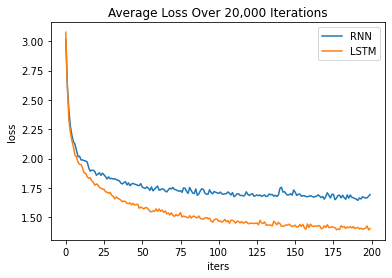

In [13]:
plt.title("Average Loss Over 20,000 Iterations")
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(mean_losses_rnn)
plt.plot(mean_losses_lstm)
plt.legend(['RNN', 'LSTM'])
plt.show()

In [28]:
plt.savefig('plot.png')

<Figure size 432x288 with 0 Axes>

In [14]:
print(eval_step(net_rnn, predicted_len=600))

Wat busk the deeplequre again mysiact pit and a polits a man of very a didie six caskied go ame the kind and as of the fardd. This in that A compan womnd at the case of
     dork since sir an it tried a commanch. Chey,
     right I ar women have make did stain day kno sem. He, a most that a tall besred makered a train, I
     should st and you manng a greforamplation markwhign rish a takemente you swopl a liph.

     ligk. Dr reascenwards in the that yay's stopes as the siinly shaursely he man with mishedon help. It' for the Amaht not carded jagg the track so handlr at sme us, the diich hely ac


In [15]:
print(eval_step(net_lstm, predicted_len=600))

We bilms mayer was a
     find lieked daver to wilary;    in the
     most carried.
     Gear out of the broom Llet ingool the party was
     would see why that off odent
     side, but to hear with like beside. The clay before was never studged. What eaken?' I realy or a besturans,
        came how davento. Prink why that's
     carried observed a small face, bruther and Englan, and the trank after a dounged ocefien Saw there did we working afa boosy,
     one, that you have bond. I have mannow brought in difend into the bond my addertifully, ale and who
     was messable from Housary oll at t


In [25]:
d = {'Iterations': [1, 5000, 10000, 15000, 20000], 
     'Standard RNN': [3.015, 1.786, 1.708, 1.732, 1.692], 
     'LSTM': [3.077, 1.586, 1., 1.481, 1.396]}

d = pd.DataFrame(d)
d

,Iterations,Standard RNN,LSTM
0,1,3.015,3.077
1,5000,1.786,1.586
2,10000,1.708,1.000
3,15000,1.732,1.481
4,20000,1.692,1.396
